In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
import os
import json
import matplotlib.lines     as mlines
# import tqdm
from scipy.stats    import gmean
import torch
from torch.autograd.functional import jacobian
from time import time


from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')

import src.mace.CSE_0D.dataset          as ds
import src.mace.CSE_0D.intregr_train    as tr
import src.mace.neuralODE               as nODE
from src.mace.CSE_0D.loss               import Loss
import src.mace.CSE_0D.loss             as loss
import src.mace.CSE_0D.plotting         as pl
import src.mace.utils                   as utils
# from src.mace.neuralODE    import Solver


specs_dict, idx_specs = utils.get_specs()

%reload_ext autoreload
%autoreload 2

### Testing input file mace_training_routine

In [84]:
inFile = '/STER/silkem/MACE/input/input_test.txt'
with open(inFile,'r') as f:
    file = f.readlines()
    lines = []
    for line in file:
        lines.append(line.split())

inputfile = {}
for i in range(len(lines)):
    if not len(lines[i]) == 0 and len(lines[i]) > 2:
        # print(test[i])
        inputfile[lines[i][0]] = lines[i][2]
    elif not len(lines[i]) == 0 and len(lines[i]) <= 2:
        print('You forgot to give an input for '+lines[i][0])

## SET PARAMETERS
lr          = float(inputfile['lr'])
tot_epochs  = int(inputfile['tot_epochs'])
nb_epochs   = int(inputfile['nb_epochs'])
ini_epochs  = 5
losstype    = inputfile['losstype']
z_dim       = int(inputfile['z_dim'])
batch_size  = 1
nb_samples  = int(inputfile['nb_samples'])
n_dim       = 468

### Retrieving the min & max values of the dataset

In [79]:
## density
rho_min = np.inf
rho_max = 0
## temperature
T_max = 0
## delta
delta_min = np.inf
delta_max = 0
## Av
Av_min = np.inf
Av_max = 0

dt_max = 0


lens = dict()

for i, path in enumerate(inputdirs):
    print(i, end='\r')

    mod = ds.CSEmod(path)

    ## check the length of the model
    if len(mod) != 135:
        lens[i] = len(mod)
    
    ## check the min and max of the parameters
    ## density
    rho_min_mod = min(mod.get_dens())
    rho_max_mod = max(mod.get_dens())
    if rho_min_mod < rho_min:
        rho_min = rho_min_mod
    if rho_max_mod > rho_max:
        rho_max = rho_max_mod
    ## Av
    Av_min_mod = min(mod.get_Av())
    Av_max_mod = max(mod.get_Av())
    if Av_min_mod < Av_min:
        Av_min = Av_min_mod
    if Av_max_mod > Av_max:
        Av_max = Av_max_mod
    ## temperature
    T_max_mod = max(mod.get_temp())
    if T_max_mod > T_max:
        T_max = T_max_mod
    ## delta
    delta_min_mod = min(mod.get_delta())
    delta_max_mod = max(mod.get_delta())
    if delta_min_mod < delta_min:
        delta_min = delta_min_mod
    if delta_max_mod > delta_max:
        delta_max = delta_max_mod

    ## dt
    dt_max_mod = max(mod.get_dt())
    if dt_max_mod > dt_max:
        dt_max = dt_max_mod

    


In [80]:
## density
print('dens:',rho_min, rho_max)
## temperature
print('temp: 10',T_max)
## delta
print('delta',delta_min, delta_max)
## Av
print('Av',Av_min, Av_max)

print('dt',dt_max)

dens: 0.008223 5009000000.0
temp: 10 1851.0
delta 0.0 0.9999
Av 2.141e-05 1246.0
dt 434800000000.0


In [83]:
meta = {'dens_min': rho_min,
        'dens_max': rho_max,
        'temp_min': 10.,
        'temp_max': T_max,
        'delta_min': delta_min,
        'delta_max': delta_max,
        'Av_min': Av_min,
        'Av_max': Av_max,
        'dt_max': dt_max
        }


json_object = json.dumps(meta, indent=4)
with open("/STER/silkem/MACE/data/minmax.json", "w") as outfile:
    outfile.write(json_object)

### Testing the dataset class

In [3]:
inputdirs = np.loadtxt('data/paths_data_C.txt', dtype=str)

In [4]:
len(inputdirs)

18314

In [15]:
inputdirs[-1]

'/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v20_T_eps/models/model_2023-01-10h12-19-34/csfrac_smooth.out'

In [13]:
for i, path in enumerate(inputdirs):
    print(i, path, end='\r')
    # try:
    mod = ds.CSEmod(path)
    # except Exception as e:
    #     print(e)
    #     print("does not exist",i, path)


In [73]:
mod = ds.CSEmod(inputdirs[18241])
dt,n,p = mod.split_in_0D()

In [41]:
dt.shape, n.shape, p.shape

((80,), (81, 468), (80, 4))

In [42]:
n = n.reshape(81,468)
n.shape

(81, 468)

In [44]:
n[:-1].shape, n[1:].shape

((80, 468), (80, 468))

In [7]:
mod1 = ds.CSEmod(inputdirs[17982])
mod2 = ds.CSEmod(inputdirs[18241])
len(mod1), len(mod2)

(135, 81)

In [90]:
dt1, n1, p1 = mod1.split_in_0D()
dt2, n2, p2 = mod2.split_in_0D()

In [91]:
dt1.shape, n1.shape, p1.shape, dt2.shape, n2.shape, p2.shape


((134,), (134, 468), (134, 4), (80,), (80, 468), (80, 4))

In [93]:
h = np.concatenate((dt1, dt2), axis=0)
h.shape

(214,)

In [33]:
def generate_random_numbers(n, start, end):
    return np.random.randint(start, end, size=n)

# Generate 10 random integers between 1 and 100
random_numbers = generate_random_numbers(10, 1, 100)

In [68]:
dt, n, p = mod.split_in_0D()
delta = p[:,2]
# norm_delta = utils.normalise(np.log10(p[:,2]), np.log10(1e-100), np.log10(1e-100+0.999))
# norm_dens = utils.normalise(mod.)
# norm_delta

delta



array([7.226e-84, 1.930e-78, 2.241e-73, 1.196e-68, 3.093e-64, 4.071e-60,
       2.854e-56, 1.113e-52, 2.514e-49, 3.414e-46, 2.887e-43, 1.570e-40,
       5.665e-38, 1.393e-35, 2.396e-33, 2.953e-31, 2.664e-29, 1.795e-27,
       9.210e-26, 3.659e-24, 1.144e-22, 2.860e-21, 5.795e-20, 9.643e-19,
       1.335e-17, 1.555e-16, 1.542e-15, 1.315e-14, 9.743e-14, 6.327e-13,
       3.634e-12, 1.861e-11, 8.565e-11, 3.569e-10, 1.355e-09, 4.723e-09,
       1.519e-08, 4.532e-08, 1.262e-07, 3.294e-07, 8.095e-07, 1.881e-06,
       4.147e-06, 8.708e-06, 1.747e-05, 3.356e-05, 6.195e-05, 1.101e-04,
       1.890e-04, 3.137e-04, 5.047e-04, 7.888e-04, 1.200e-03, 1.778e-03,
       2.573e-03, 3.641e-03, 5.045e-03, 6.855e-03, 9.145e-03, 1.199e-02,
       1.548e-02, 1.968e-02, 2.468e-02, 3.053e-02, 3.732e-02, 4.508e-02,
       5.388e-02, 6.373e-02, 7.465e-02, 8.666e-02, 9.974e-02, 1.139e-01,
       1.290e-01, 1.451e-01, 1.622e-01, 1.800e-01, 1.987e-01, 2.180e-01,
       2.380e-01, 2.585e-01, 2.795e-01, 3.008e-01, 

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out


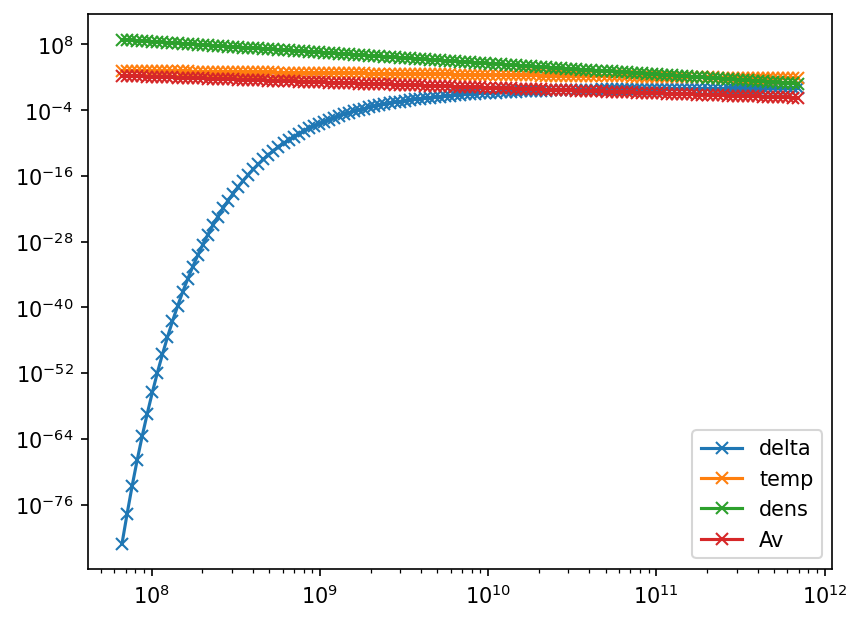

In [116]:
i = 2898-1
mod = ds.CSEmod(inputdirs[i])
print(inputdirs[i])


a=0.5

y = 0.01
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
y = 1.e-40
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
plt.loglog(mod.time, mod.get_delta(), '-x', label = 'delta')#, alpha = a)
plt.loglog(mod.get_time(), mod.get_temp(), '-x', label = 'temp')
plt.loglog(mod.get_time(), mod.get_dens(), '-x', label = 'dens')
plt.loglog(mod.get_time(), mod.get_Av(), '-x', label = 'Av')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CO' ),label = 'CO')
# plt.loglog(mod.get_time(), mod.get_abs_spec('H2O'),label = 'H2O')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CH4'),label = 'CH4')
# plt.loglog(mod.get_time(), mod.n[:,-2],label = 'e-')

plt.legend()
plt.show()

### Testing the training

In [6]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-4
tot_epochs = 1
nb_epochs  = 7
ini_epochs = 2
losstype = 'mse_grd_idn_rel'
# losstype = 'mse'
z_dim = 16
dt_fract = 0.2
batch_size = 1
nb_samples = 10000
n_dim = 468

print('------------------------------')
print('      # epochs:', ini_epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fract,nb_samples=nb_samples, batch_size=batch_size, kwargs=kwargs)

------------------------------
      # epochs: 2
 learning rate: 0.0001
# z dimensions: 16
     # samples: 10000
     loss type: mse_grd_idn_rel

Dataset:
------------------------------
total # of samples: 10000
# training samples: 7000
#  testing samples: 3000
             ratio: 0.3


In [40]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/'


## other learning rates
dirname = '2023-12-13 18:19:22.522359'  ## lr = 1.e-4       GOOD MODEL

meta, model = utils.load_all(outloc, dirname, sepr = True, epoch = 7)   # type: ignore

for i, (n,p,dt) in enumerate(data_loader):
    print(n.shape, p.shape, dt.shape)
    n  = n.view(n.shape[1], n.shape[2]).to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device
    p  = p.view(p.shape[1], p.shape[2]).to(DEVICE) 
    dt = dt.view(dt.shape[1]).to(DEVICE)

    print(n.shape, p.shape, dt.shape)

    tstep_evol = 20
    n0 = n[0:-tstep_evol]
    p0 = p[0:-tstep_evol]
    dt0 = dt[0:-tstep_evol]

    print(n0.shape, p0.shape, dt0.shape)

    nhat_evol = list()
    n_evol = list()
    
    n_hat, z_hat, modstatus = model(n0[:-1],p0,dt0)   
    n_hat = n_hat.view(-1, 468)
    nhat_evol.append(n_hat)
    n_evol.append(n[0:-tstep_evol+0][:-1])

    print(n_hat.shape)

    ## subsequent steps of the evolution
    for i in range(1,tstep_evol):
        n_hat,z_hat, modstatus = model(n_hat,p[i:-tstep_evol+i],dt[i:-tstep_evol+i])   
        # print('shape nhat',n_hat.shape)
        n_hat = n_hat.view(-1, 468) 
        nhat_evol.append(n_hat)
        n_evol.append(n[i:-tstep_evol+i][:-1])

    nhat_evol = torch.stack(nhat_evol).permute(1,0,2)
    n_evol = torch.stack(n_evol).permute(1,0,2)

    print(nhat_evol.shape, n_evol.shape)

    nhat_evol = nhat_evol.detach().numpy()
    n_evol = n_evol.detach().numpy()


The model has 76388 trainable parameters
torch.Size([1, 135, 468]) torch.Size([1, 134, 4]) torch.Size([1, 134])
torch.Size([135, 468]) torch.Size([134, 4]) torch.Size([134])
torch.Size([115, 468]) torch.Size([114, 4]) torch.Size([114])
torch.Size([114, 468])
torch.Size([114, 20, 468]) torch.Size([114, 20, 468])
torch.Size([1, 135, 468]) torch.Size([1, 134, 4]) torch.Size([1, 134])
torch.Size([135, 468]) torch.Size([134, 4]) torch.Size([134])
torch.Size([115, 468]) torch.Size([114, 4]) torch.Size([114])
torch.Size([114, 468])
torch.Size([114, 20, 468]) torch.Size([114, 20, 468])
torch.Size([1, 135, 468]) torch.Size([1, 134, 4]) torch.Size([1, 134])
torch.Size([135, 468]) torch.Size([134, 4]) torch.Size([134])
torch.Size([115, 468]) torch.Size([114, 4]) torch.Size([114])
torch.Size([114, 468])
torch.Size([114, 20, 468]) torch.Size([114, 20, 468])


In [54]:
avg = np.mean(n_evol, axis=1)

avg.shape, avg

((126, 468),
 array([[ 0.05529028,  0.05159849,  0.07650405, ..., -0.00813774,
          0.00024102,  0.03813865],
        [ 0.05525771,  0.053205  ,  0.07595718, ..., -0.00813935,
         -0.00021451,  0.04052645],
        [ 0.05484792,  0.05388338,  0.07575265, ..., -0.0081016 ,
         -0.00022981,  0.04183636],
        ...,
        [ 0.05528894,  0.04903455,  0.0804325 , ..., -0.00765201,
          0.0025761 ,  0.03565256],
        [ 0.05530045,  0.04901724,  0.08052422, ..., -0.00764722,
          0.0025735 ,  0.03568514],
        [ 0.0553114 ,  0.04899952,  0.08061729, ..., -0.00764273,
          0.00257011,  0.03571947]]))

In [20]:
n_sample = n_evol[0]

n_sample.T[i].shape

(8,)

(114, 20, 468)


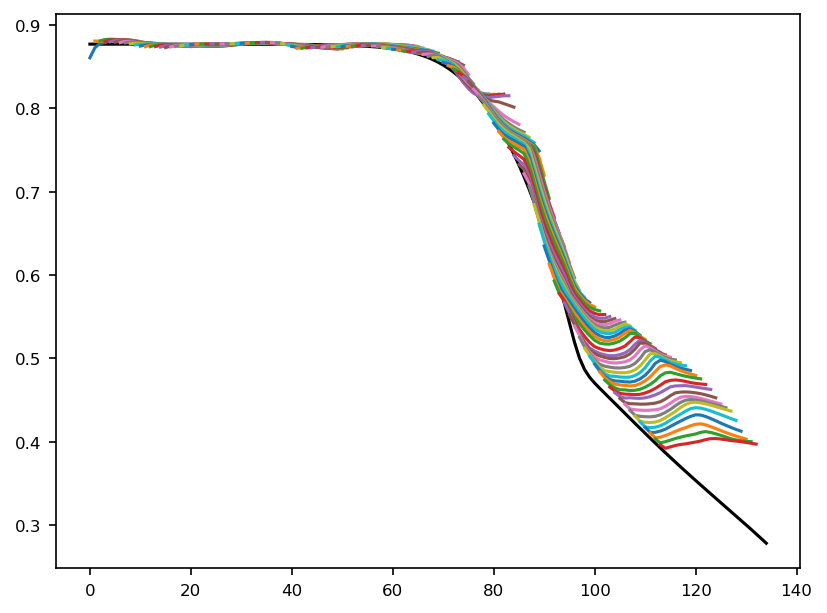

In [41]:
spec = 71
print(nhat_evol.shape)
plt.plot(n.T[spec], 'k')

for j in range(0,nhat_evol.shape[0]):
    n_sample_hat = nhat_evol[j]
    n_sample = n_evol[j]
    # print(n_sample.shape)
    # print(j)
    plt.plot(np.arange(j,j+tstep_evol),n_sample_hat.T[spec],'-')
    # plt.plot(np.arange(j,j+tstep_evol),n_sample.T[spec]+1,'-')

# plt.show()
# for j in range(n_evol.shape[0]):
#     plt.plot(np.linspace(j,j+tstep_evol,tstep_evol))
# plt.show()
#np.linspace(j,j+tstep_evol,tstep_evol)

In [61]:
testinput = train.get_test()

['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out']


In [56]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

num_params = utils.count_parameters(model)
print(f'The model has {num_params} trainable parameters\n')


norm = {'mse' : 1,
        'rel' : 1,
        'grd' : 1,
        'idn' : 1}

fract = {'mse' : 1, 
         'rel' : 1,
         'grd' : 1,
         'idn' : 1}


## Make loss objects
trainloss = Loss(norm, fract)
testloss  = Loss(norm, fract)

trainloss.set_losstype(losstype)
testloss.set_losstype(losstype)

nb_epochs = 20

tic = time()
opt = tr.train(model, lr, data_loader, test_loader,nb_evol=nb_epochs, path =None, end_epochs = ini_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_time = time())
toc = time()

print('\nTraining time [s]:',toc-tic)




The model has 289508 trainable parameters

Model:         
learning rate: 0.0001
loss type:     mse_grd_idn_rel

>>> Training model...

Epoch 1 complete! 	Average loss train:  0.7117281588642297 	Average loss test:  0.35115987425019446
              time [hours]:  0.0005226771699057685
Epoch 2 complete! 	Average loss train:  0.7016534216071416 	Average loss test:  0.3459510608601384
              time [hours]:  0.0010623079538345337

 	DONE!

Training time [s]: 3.8255748748779297


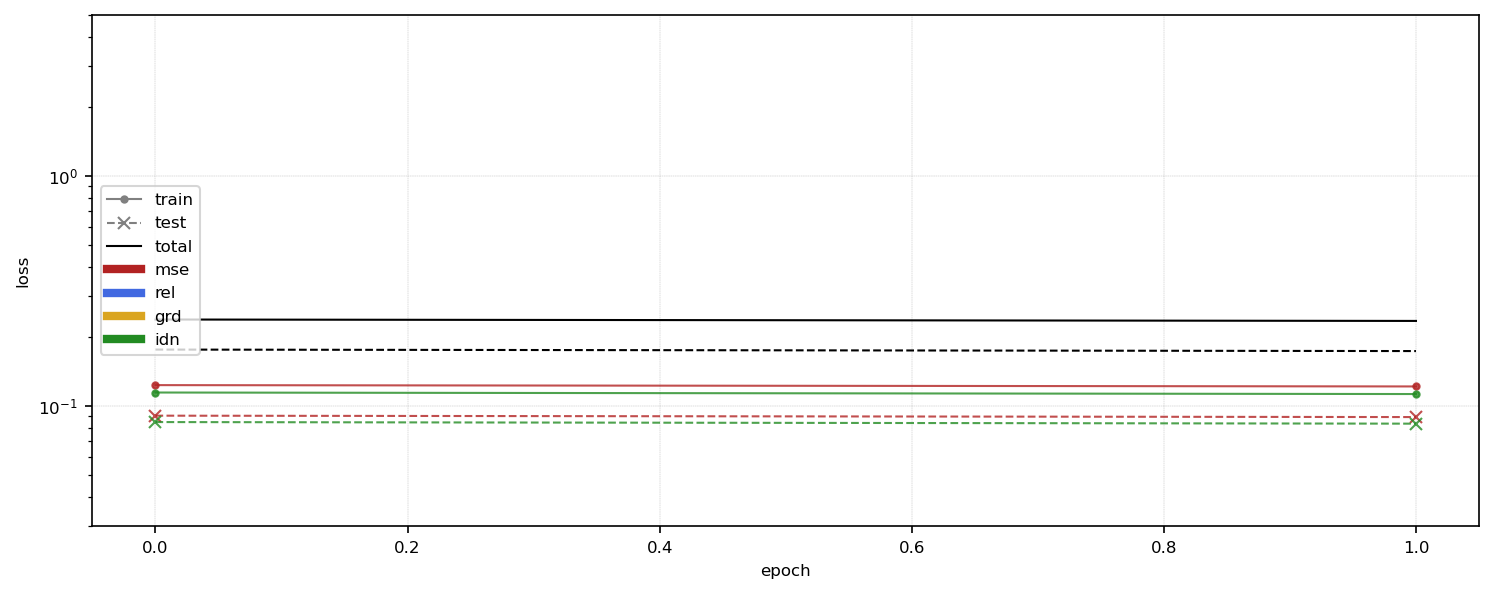

In [58]:
fig = pl.plot_loss(trainloss, testloss, log = True, ylim = True, limits = [3e-2,5e0])

plt.show()

In [34]:
mse, rel, grd, idn, elm = trainloss.get_all_losses()

In [37]:
grd

array([ 0.04522101,  0.0677269 ,  0.58443195,  0.3054803 ,  0.2440507 ,
        0.22461338,  0.20902135, 40.68049504, 22.56937639, 19.43974964])

### Testing trained models

The model has 285476 trainable parameters

META DATA
nb_samples 10000
lr 3e-05
epochs 100
z_dim 10
dt_fract 0.175
tmax 434800000000.0
train_time_h 52.11617968877157
overhead_s 0.49984073638916016
samples 7000
cutoff_abs 1e-20
done true
losstype mse_idn
inputfile input_mse6


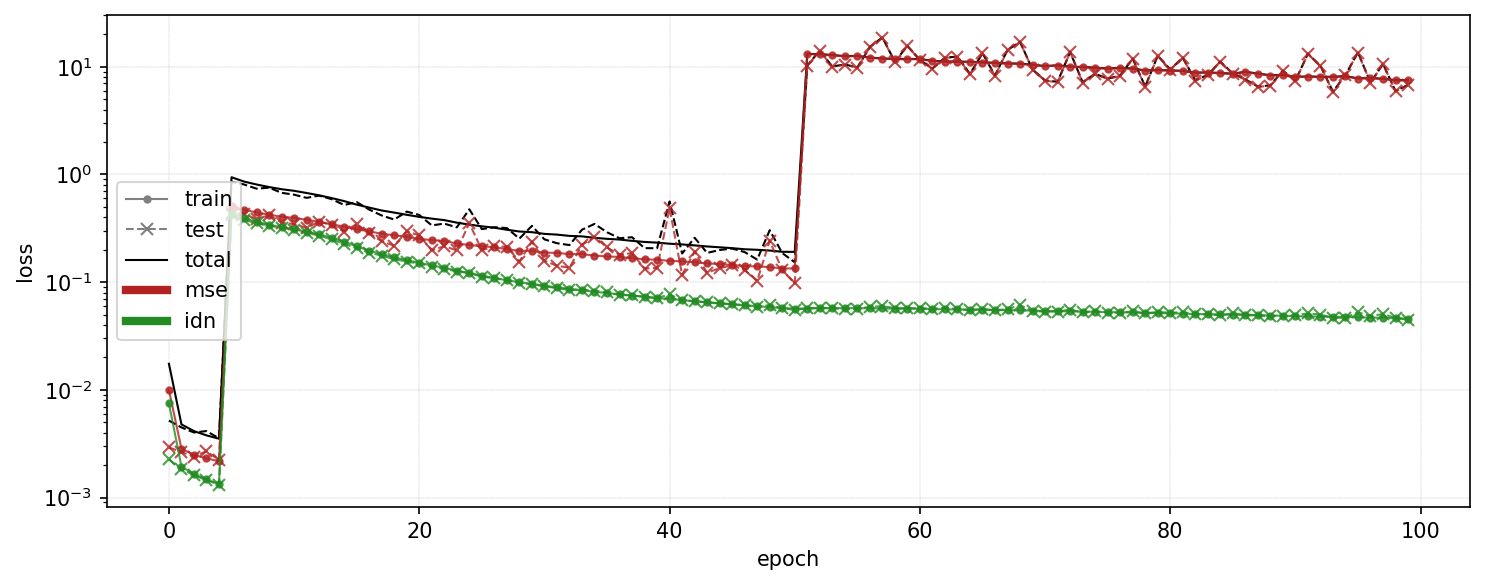

In [14]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/'



## other learning rates
dirname = '2023-12-13 18:19:22.522359'  ## lr = 1.e-4       GOOD MODEL
# dirname = '2023-12-13 18:21:02.617224'  ## lr = 1.e-2
# dirname = '2023-12-18 10:51:34.569065'  ## lr = 1.e-5



## evolution training
# dirname = '20240106_102404_58729_1'     ## zdim = 16
# dirname = '20240106_102404_58729_2'     ## zdim = 8
# dirname = '20240106_102404_58729_4'     ## zdim = 16, lr = 3e-5
# dirname = '20240106_102404_58729_5'     ## zdim = 8, lr = 3e-5
dirname = '20240106_102404_58729_6'


meta_, model_, trainloss_, testloss_ = utils.load_all(outloc, dirname, epoch = 6) # type: ignore
# meta_, model_, trainloss_, testloss_ = utils.load_all(outloc, dirname, sepr = False) # type: ignore

print('\nMETA DATA')
for key in meta_:
    print(key, meta_[key])
    
plots_path = outloc+dirname+'/plots/'
utils.makeOutputDir(plots_path)

if not os.path.exists(outloc+dirname+"/testloss.json"):
    testloss = {}
    json_loss = json.dumps(testloss, indent=4)
    with open(outloc+dirname+"/testloss.json", "w") as outfile:
        outfile.write(json_loss)

        
fig = pl.plot_loss(trainloss_, testloss_, log = True, ylim = False, limits = [1e-4,1e1])#, notest = False)
plt.savefig(plots_path+'loss.png')

['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-03-58/csfrac_smooth.out']
torch.Size([134, 468])


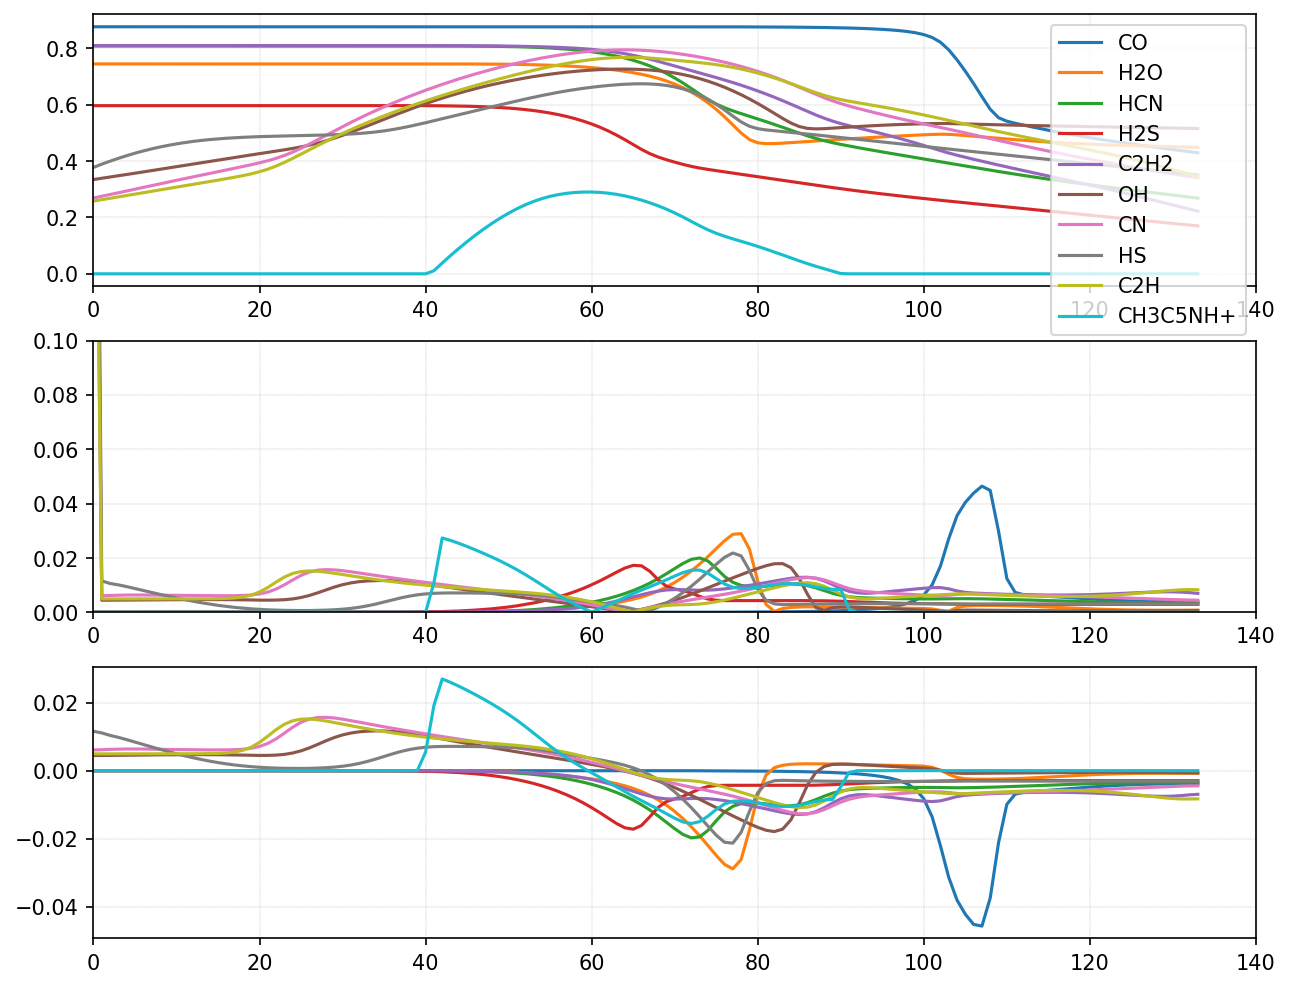

In [18]:
fig, axs = plt.subplots(3,1, gridspec_kw={'height_ratios': [4,4,4]},figsize=(10, 8))
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
model_testing = model_

input = train.get_test()
n = input[0]
# print(n.max())
cutoff = 1e-20
nmin = np.log10(cutoff)
nmax = np.log10(0.85e-1)

n_transf = n



spec = 'CO'
specs = ['CO', 'H2O', 'HCN', 'H2S','C2H2', 'OH', 'CN', 'HS', 'C2H', 'CH3C5NH+']

# idx = 71
eps = 1e-10
n_0 = n_transf[:-1]
# print(np.where(n_0==0))
grad = (n_transf[1:]-n_0)
torchgrad = torch.gradient(n[1:])[0]
print(torchgrad.shape)
# print(grad.shape)
# for i in range(grad.shape[1]):
for spec in specs:
    idx = specs_dict[spec]
    ax1.plot(n_transf[1:,idx], label = idx_specs[idx])
    ax2.plot(np.abs(grad[:,idx]))
    ax3.plot((torchgrad[:,idx]))
# ax2.set_yscale('log')
# ax3.set_yscale('log')
ax2.set_ylim([0,1e-1])
# ax3.set_ylim([0,1e-1])
for ax in axs:
    # ax.set_yscale('log')
    ax.set_xlim([0,140])
    ax.grid(True, linestyle = '--', linewidth = 0.2)
ax1.legend()
plt.show()

In [15]:

model_testing = model_
specs = ['CO', 'H2O', 'HCN', 'H2S','C2H2', 'OH', 'CN', 'HS', 'C2H', 'CH3C5NH+']




In [19]:
def test_model(model_testing,  specs = specs, plots_path = plots_path, save = False):
    testpaths = train.testpath

    avg_step = list()
    std_step = list()
    sum_step = list()

    avg_evol = list()
    std_evol = list()
    sum_evol = list()

    mods = list()

    for testpath in testpaths:
        print(testpath)
        input, info = ds.get_test_data(testpath,train)

        save = True
        title = info['path'] +'_'+ info['name']
        mods.append(title)

        n, n_hat, t, comptime = tr.test(model_testing, input)
        start_idx = 0
        n_evol, mace_time = tr.test_evolution(model_testing, input, start_idx=start_idx)

        print('\n>> Denormalising abundances...')
        n = ds.get_abs(n)
        n_hat = ds.get_abs(n_hat)
        n_evol = ds.get_abs(n_evol)

        print('\n>> Calculating & saving losses...')
        # print('per t    ime step:')
        mse = loss.mse_loss(n[1:], n_hat)
        avg_step.append(mse.mean())
        std_step.append(mse.std())
        sum_step.append(mse.sum())
        losses_step = [mse.mean(), mse.std(), mse.sum()]

        # print('    evolution:')
        mse_evol = loss.mse_loss(n[1:], n_evol)
        avg_evol.append(mse_evol.mean())
        std_evol.append(mse_evol.std())
        sum_evol.append(mse_evol.sum())
        losses_evol = [mse_evol.mean(), mse_evol.std(), mse_evol.sum()]

        testloss = {title: losses_step,
                    title: losses_evol,
                    }
        
        with open(outloc+dirname+"/testloss.json", "r") as outfile:
            testloss_old = json.load(outfile)
        testloss_old.update(testloss)
        print(testloss_old)
        with open(outloc+dirname+"/testloss.json", "w") as outfile:
            json.dump(testloss_old, outfile, indent=4)

        plotting = False
        if plotting == True:
            print('\n>> Plotting...')

            ## --------------- Neural model - per time step ----------------- ##
            pl.plot_compare(n, n_hat, plots_path, 'timestep_'+title, alpha = 0.5, j = -1, save=True)
            pl.plot_abs(    n, n_hat, plots_path, 'timestep_'+title, specs=specs, save=save)

            ## --------------- Neural model - evolution ----------------- ##

            pl.plot_compare(n, n_evol, plots_path, 'evolution_'+title, alpha = 0.5, j = -1, save=True)
            pl.plot_abs(    n, n_evol, plots_path, 'evolution_'+title,specs=specs, save=save)

        print('Done!')
        print('----------------------------------------\n')

    return np.array(avg_step), np.array(std_step), np.array(sum_step), np.array(avg_evol), np.array(std_evol), np.array(sum_evol), mods

In [16]:
avg_step, std_step, sum_step, avg_evol, std_evol, sum_evol, mods = test_model(model_testing, specs = specs, plots_path = plots_path, save = False)



x = np.linspace(1,22,22)



fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot((111))



c1 = 'firebrick'
m1 = 'o'
m2 = 'x'
a=0.8
# ax1.plot(x,avg_step,marker =m,color=c, label = 'avg')
ax1.errorbar(x,avg_step,std_step, marker=m1, color = c1,linestyle = 'none', label = 'std', alpha = a)
# ax1.plot(avg_step-std_step,'o', label = 'std')
ax1.plot(x,sum_step,marker = m2,c=c1, label = 'sum',linestyle = 'none')

c2 = 'steelblue'
ax1.errorbar(x,avg_evol,std_evol, marker=m1,color=c2, linestyle = 'none', label = 'std', alpha = a)
# ax1.plot(avg_step-std_step,'o', label = 'std')
ax1.plot(x,sum_evol,marker=m2,c=c2, label = 'sum', linestyle = 'none')



ax1.set_yscale('log')

ax1.set_xlabel('model')
ax1.set_ylabel('MSE')
from matplotlib.ticker import FixedLocator
ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(mods, rotation=90)

ax1.grid(True, linestyle='--', linewidth=0.1, color='gray')

l_avg = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = m1, label='average')
l_sum = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = m2, label='sum')
l_step = mlines.Line2D([],[], color = c1, ls = '-' , label='step',lw = 5)
l_evol = mlines.Line2D([],[], color = c2, ls = '-' , label='evol',lw = 5)
handles = [l_avg, l_sum, l_step, l_evol]

plt.legend(handles=handles, loc='center right')

plt.tight_layout()
plt.savefig(plots_path+'mse.png')
plt.show()

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.007578134536743164

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 214.93it/s]


Solving time [s]: 0.00473475456237793
Total   time [s]: 0.6243414878845215

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [2.9818067247351843e-05, 0.0012831670002631222, 1.8699506332159288]}
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009731292724609375

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 164.45it/s]


Solving time [s]: 0.0073282718658447266
Total   time [s]: 0.8174381256103516

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [2.9818067247351843e-05, 0.0012831670002631222, 1.8699506332159288], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [3.814299938506668e-05, 0.0013701735559039248, 2.3920237774363016]}
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.009388923645019531

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 155.41it/s]


Solving time [s]: 0.005971193313598633
Total   time [s]: 0.8653342723846436

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [2.9818067247351843e-05, 0.0012831670002631222, 1.8699506332159288], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [3.814299938506668e-05, 0.0013701735559039248, 2.3920237774363016], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [1.9690536456419003e-05, 0.0010577299399760398, 1.2348329222549486]}
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008637666702270508

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 179.58it/s]


Solving time [s]: 0.005474567413330078
Total   time [s]: 0.7493143081665039

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [2.9818067247351843e-05, 0.0012831670002631222, 1.8699506332159288], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [3.814299938506668e-05, 0.0013701735559039248, 2.3920237774363016], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [1.9690536456419003e-05, 0.0010577299399760398, 1.2348329222549486], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [3.47047672127745e-05, 0.0012755071106246997, 2.176405361447514]}
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.008209228515625

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 179.85it/s]


Solving time [s]: 0.005948781967163086
Total   time [s]: 0.7472939491271973

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [2.9818067247351843e-05, 0.0012831670002631222, 1.8699506332159288], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [3.814299938506668e-05, 0.0013701735559039248, 2.3920237774363016], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [1.9690536456419003e-05, 0.0010577299399760398, 1.2348329222549486], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [3.47047672127745e-05, 0.0012755071106246997, 2.176405361447514], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [1.7389208022535526e-05, 0.0010539698574456723, 1.0905120135092479]}
Done!
----------------------------------------

/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out


KeyboardInterrupt: 


________20240106_102404_58729_0_______________________________________________


The model has 285476 trainable parameters
/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out
>>> Testing model...
Solving time [s]: 0.006474733352661133

>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 164.13it/s]


Solving time [s]: 0.0067369937896728516
Total   time [s]: 0.8170380592346191

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216,

100%|██████████| 133/133 [00:00<00:00, 147.30it/s]


Solving time [s]: 0.006383180618286133
Total   time [s]: 0.9132041931152344

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 155.30it/s]


Solving time [s]: 0.007153987884521484
Total   time [s]: 0.8647069931030273

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 155.86it/s]


Solving time [s]: 0.0062906742095947266
Total   time [s]: 0.8639769554138184

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216,

100%|██████████| 133/133 [00:00<00:00, 161.43it/s]


Solving time [s]: 0.0060214996337890625
Total   time [s]: 0.8324844837188721

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216,

100%|██████████| 133/133 [00:00<00:00, 172.08it/s]


Solving time [s]: 0.005383968353271484
Total   time [s]: 0.7810509204864502

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 175.13it/s]


Solving time [s]: 0.006661415100097656
Total   time [s]: 0.767981767654419

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 4

100%|██████████| 133/133 [00:00<00:00, 186.51it/s]


Solving time [s]: 0.004663705825805664
Total   time [s]: 0.7210960388183594

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 166.20it/s]


Solving time [s]: 0.004616975784301758
Total   time [s]: 0.8089320659637451

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 173.79it/s]


Solving time [s]: 0.005207538604736328
Total   time [s]: 0.7727811336517334

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 183.86it/s]


Solving time [s]: 0.005161285400390625
Total   time [s]: 0.7315866947174072

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 173.51it/s]


Solving time [s]: 0.00619196891784668
Total   time [s]: 0.7756526470184326

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 4

100%|██████████| 133/133 [00:00<00:00, 160.34it/s]


Solving time [s]: 0.005849361419677734
Total   time [s]: 0.8380367755889893

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 170.00it/s]


Solving time [s]: 0.005960226058959961
Total   time [s]: 0.7914185523986816

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 167.94it/s]


Solving time [s]: 0.00541377067565918
Total   time [s]: 0.8010299205780029

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 4

100%|██████████| 79/79 [00:00<00:00, 119.18it/s]


Solving time [s]: 0.009612321853637695
Total   time [s]: 0.6725249290466309

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 158.07it/s]


Solving time [s]: 0.006525516510009766
Total   time [s]: 0.8516330718994141

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 169.13it/s]


Solving time [s]: 0.00667572021484375
Total   time [s]: 0.7956292629241943

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 4

100%|██████████| 79/79 [00:00<00:00, 164.30it/s]


Solving time [s]: 0.005462646484375
Total   time [s]: 0.49284958839416504

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 4.

100%|██████████| 133/133 [00:00<00:00, 156.10it/s]


Solving time [s]: 0.0063130855560302734
Total   time [s]: 0.8618214130401611

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216,

100%|██████████| 133/133 [00:00<00:00, 164.16it/s]


Solving time [s]: 0.006383419036865234
Total   time [s]: 0.8196306228637695

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216, 

100%|██████████| 133/133 [00:00<00:00, 159.95it/s]


Solving time [s]: 0.0061337947845458984
Total   time [s]: 0.8399350643157959

>> Denormalising abundances...

>> Calculating & saving losses...
{'Mdot1e-6_v12-5_model_2022-12-23h11-00-25': [0.00012226301094583867, 0.004610552164559127, 7.667357942435435], 'Mdot1e-7_v15_model_2022-12-28h14-46-56': [0.00010541065243933034, 0.014098805613134079, 6.6105128357752845], 'Mdot1e-5_v20_model_2022-12-27h14-09-37': [2.0925443042410407e-05, 0.001065173723191102, 1.3122763840756415], 'Mdot5e-7_v15_model_2022-12-23h15-59-16': [9.732227363804641e-05, 0.004350405839711087, 6.103274424389166], 'Mdot2e-5_v22-5_model_2022-12-27h18-35-08': [2.289782081936497e-05, 0.0010976321597726557, 1.435968139224016], 'Mdot1e-8_v25_model_2022-12-27h02-09-43': [0.00014182022500546434, 0.017281886508251496, 8.89382995054268], 'Mdot2e-7_v7-5_model_2022-12-23h15-01-36': [9.172086152633905e-05, 0.0036262677170345496, 5.751998668039774], 'Mdot5e-7_v10_model_2022-12-24h12-17-41': [7.88474119658842e-05, 0.0026303481220903216,

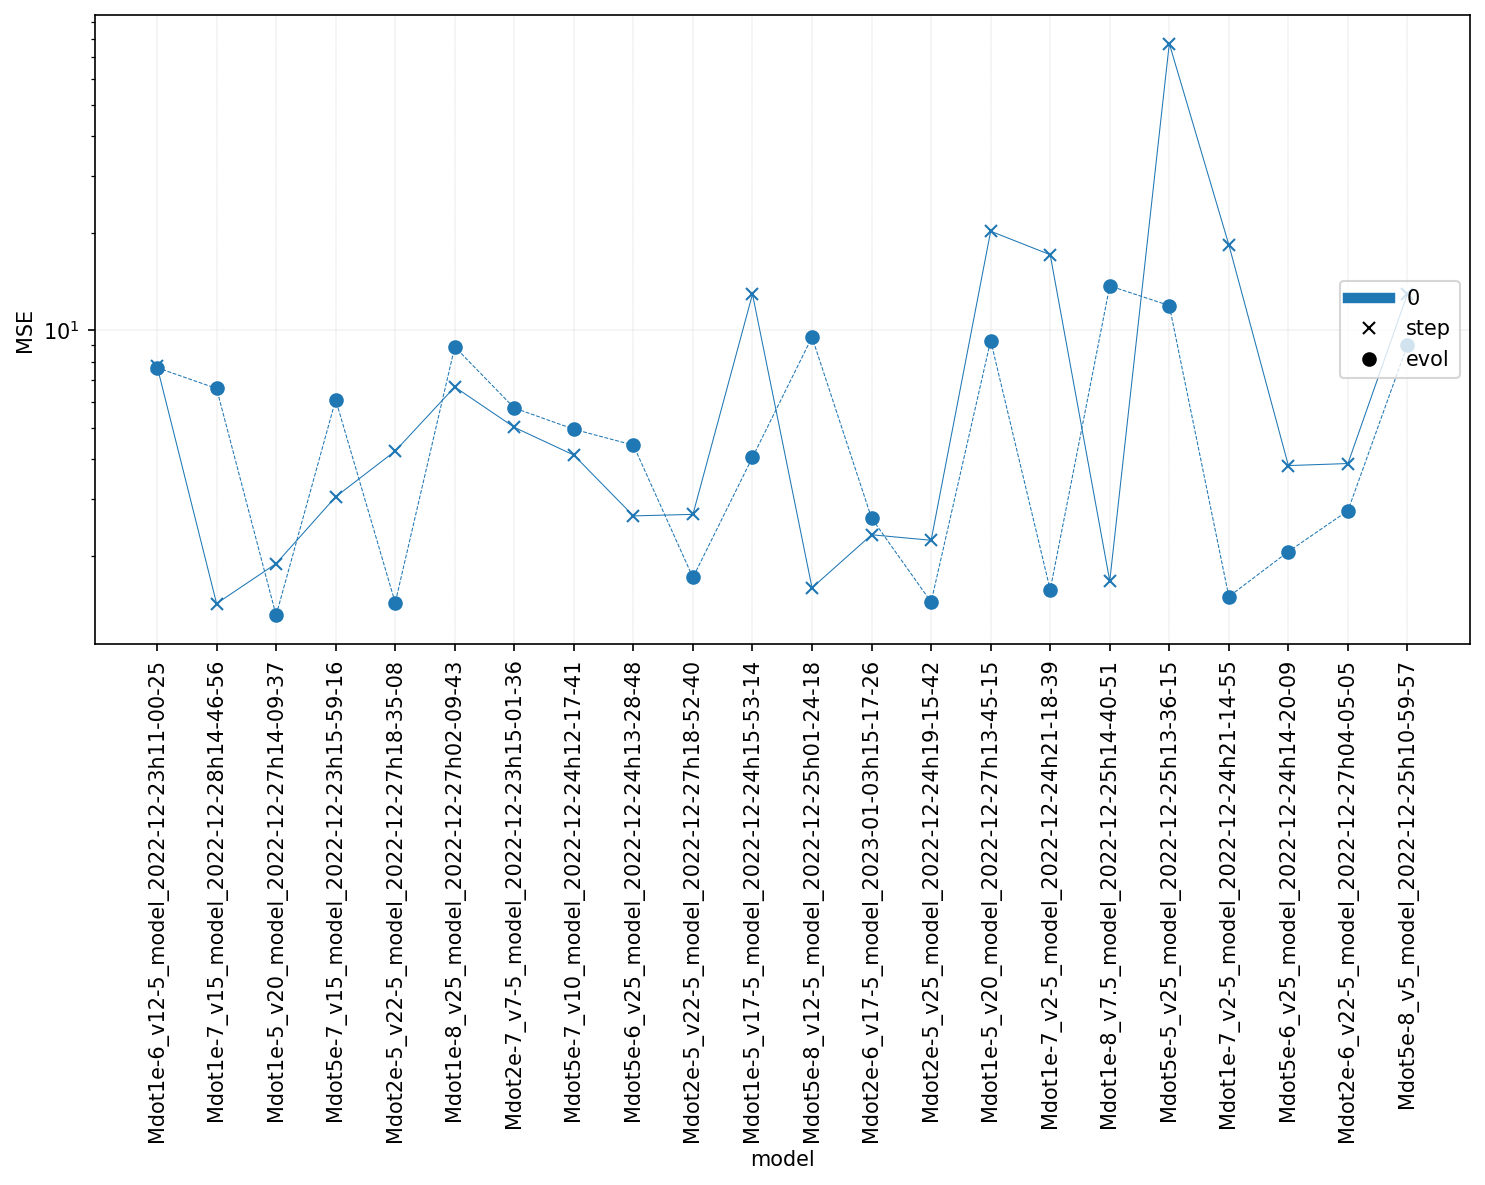

In [29]:
idx = ['0']#, '1', '2']#, '3', '4', '5', '6']


x = np.linspace(1,22,22)

fig = plt.figure(figsize = (10,8))
ax1 = fig.add_subplot((111))
lw = 0.5
handles = list()

for i in range(len(idx)):
    dirname = '20240106_102404_58729_'+idx[i]
    print('\n________'+dirname+'_______________________________________________\n\n')

    meta_, model_, trainloss_, testloss_ = utils.load_all(outloc, dirname, epoch = 6) # type: ignore
    plots_path = outloc+dirname+'/plots/'
    utils.makeOutputDir(plots_path)

    if not os.path.exists(outloc+dirname+"/testloss.json"):
        testloss = {}
        json_loss = json.dumps(testloss, indent=4)
        with open(outloc+dirname+"/testloss.json", "w") as outfile:
            outfile.write(json_loss)
    
    avg_step, std_step, sum_step, avg_evol, std_evol, sum_evol, mods = test_model(model_, specs = specs, plots_path = plots_path, save = False)
    
    line, = ax1.plot(x,sum_step,marker ='x', linestyle = '-', lw = lw)
    ax1.plot(x,sum_evol,marker ='o', linestyle = '--',color = line.get_color(),  lw = lw)
    leg = mlines.Line2D([],[], color = line.get_color(), ls = '-' , lw = 5, label = idx[i])
    handles.append(leg)

ax1.set_yscale('log')

ax1.set_xlabel('model')
ax1.set_ylabel('MSE')

from matplotlib.ticker import FixedLocator
ax1.xaxis.set_major_locator(FixedLocator(x))
ax1.set_xticklabels(mods, rotation=90)

ax1.grid(True, linestyle='--', linewidth=0.1, color='gray')

l_step = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = 'x', label='step')
l_evol = mlines.Line2D([],[], color = 'k', ls = 'none' , marker = 'o', label='evol')

handles.append(l_step)
handles.append(l_evol)

plt.legend(handles = handles, loc='center right')

plt.tight_layout()
# plt.savefig(plots_path+'mse.png')
plt.show()

### Testing jacobian

In [152]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

z = torch.randn(134,10, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')

M = torch.from_numpy(M).to_sparse()



In [153]:
A = model.g.A
B = model.g.B
C = model.g.C
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True).view(468,134,134,-1)

In [152]:
tic = time()
ode = C + torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z) 
toc = time()
print('time:', toc-tic)

time: 0.0006093978881835938


In [9]:
Aode = torch.einsum("ij, bj -> bi", A, z)
Aode.shape

torch.Size([134, 10])

In [148]:
Bode = torch.einsum("ijk, bj, bk -> bi", B, z, z)
Bode.shape

torch.Size([134, 10])

In [145]:
(z.unsqueeze(-1)* z.unsqueeze(1) ).shape

torch.Size([134, 10, 10])

In [154]:
tic = time()
Aode = z@A
Bode = (B @ (z.unsqueeze(-1) * z.unsqueeze(1)).T).sum()
toc = time()
print('time:', toc-tic)

print(C.shape , Aode.shape, Bode.shape)

ode = C+Aode+Bode



time: 0.0010347366333007812
torch.Size([10]) torch.Size([134, 10]) torch.Size([])


In [169]:

tic = time()
L0 = torch.einsum("NZ , Nbci , i   -> bcZ  ", M , jac_D , C)
L1 = torch.einsum("NZ , Nbci , ij  -> bcZj ", M , jac_D , A)
L2 = torch.einsum("NZ , Nbci , ijk -> bcZjk", M , jac_D , B)
toc = time()

print(toc-tic)
L0.shape, L1.shape, L2.shape

1.018272876739502


(torch.Size([134, 134, 14]),
 torch.Size([134, 134, 14, 10]),
 torch.Size([134, 134, 14, 10, 10]))

In [87]:
C.shape, A.shape, B.shape, z.shape, jac_D.shape, M.shape

(torch.Size([10]),
 torch.Size([10, 10]),
 torch.Size([10, 10, 10]),
 torch.Size([134, 10]),
 torch.Size([468, 134, 134, 10]),
 torch.Size([468, 14]))

In [177]:
tic = time()
L_0 = (jac_D @ C).T @ M
toc = time()
L_0.shape, toc-tic

(torch.Size([134, 134, 14]), 0.6680154800415039)

In [171]:
(L0-L_0).sum()

tensor(3.1974e-14, grad_fn=<SumBackward0>)

In [178]:
tic = time()
L_1 = (jac_D @ model.g.A).T @ M
toc = time()
L_1.shape, toc-tic

(torch.Size([10, 134, 134, 14]), 5.053350448608398)

In [173]:
(L1-L_1.view(134,134,-1,10)).sum()

tensor(0., grad_fn=<SumBackward0>)

In [193]:
L2 = (jac_D @ model.g.B)

RuntimeError: The size of tensor a (134) must match the size of tensor b (10) at non-singleton dimension 1

In [191]:
jac_D.shape, model.g.B.shape

(torch.Size([468, 134, 134, 10]), torch.Size([10, 10, 10]))

### Testing gradient loss

In [ ]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

z = torch.randn(134,10, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')

M = torch.from_numpy(M).to_sparse()



In [ ]:
A = model.g.A
B = model.g.B
C = model.g.C
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True).view(468,134,134,-1)

In [64]:
## import own functions
sys.path.insert(1, '/STER/silkem/ChemTorch/src/')
import ode.acodes   as odes
import rates    as rates
import input    as input

In [65]:
data = ds.CSEdata( nb_samples=10000, dt_fract=dt_fract)

i = 0
path = data.path[i]

n,p,dt = data[i]

path

'/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v10_T_eps/models/model_2022-12-23h17-45-41/csfrac_smooth.out'

In [66]:
mod = ds.CSEmod(path)

In [67]:
dt_or, n_or, p_or = mod.split_in_0D()
n_or = np.clip(n_or, 1e-20, None)

In [68]:
n = ds.get_abs(n)
p = ds.get_phys(p, data)

In [69]:
(p-p_or).sum()

tensor(-1.1457e-08)

In [75]:
print(np.abs(n-n_or))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.9968e-15],
        [1.3764e-21, 4.5438e-28, 2.7610e-29,  ..., 0.0000e+00, 8.6027e-23,
         3.9968e-15],
        [4.8704e-21, 6.5633e-28, 3.9443e-30,  ..., 0.0000e+00, 1.3235e-22,
         3.9968e-15],
        ...,
        [6.5052e-19, 1.6941e-21, 1.8933e-29,  ..., 0.0000e+00, 0.0000e+00,
         2.7200e-15],
        [6.5052e-19, 1.2705e-20, 1.8933e-29,  ..., 0.0000e+00, 2.3852e-18,
         2.7200e-15],
        [3.2526e-19, 8.4703e-22, 1.8933e-29,  ..., 0.0000e+00, 1.9516e-18,
         2.7200e-15]])


In [71]:
n

tensor([[1.0000e-20, 1.0000e-20, 1.0000e-20,  ..., 1.0000e-20, 1.0000e-20,
         5.0000e-01],
        [5.1950e-07, 2.9690e-13, 5.2490e-15,  ..., 1.0000e-20, 3.1180e-08,
         5.0000e-01],
        [1.1290e-06, 3.4390e-13, 6.2880e-15,  ..., 1.0000e-20, 5.9860e-08,
         5.0000e-01],
        ...,
        [3.4320e-04, 3.9550e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1790e-04,
         4.9980e-01],
        [3.4390e-04, 4.3380e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1830e-04,
         4.9980e-01],
        [3.4470e-04, 4.7510e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1880e-04,
         4.9980e-01]])

In [72]:
n_or

array([[1.000e-20, 1.000e-20, 1.000e-20, ..., 1.000e-20, 1.000e-20,
        5.000e-01],
       [5.195e-07, 2.969e-13, 5.249e-15, ..., 1.000e-20, 3.118e-08,
        5.000e-01],
       [1.129e-06, 3.439e-13, 6.288e-15, ..., 1.000e-20, 5.986e-08,
        5.000e-01],
       ...,
       [3.432e-04, 3.955e-06, 1.283e-14, ..., 1.000e-20, 5.179e-04,
        4.998e-01],
       [3.439e-04, 4.338e-06, 1.283e-14, ..., 1.000e-20, 5.183e-04,
        4.998e-01],
       [3.447e-04, 4.751e-06, 1.283e-14, ..., 1.000e-20, 5.188e-04,
        4.998e-01]])

### Random testing

In [21]:
cols = plt.rcParams['axes.prop_cycle'].by_key()
cols

{'color': ['#1f77b4',
  '#ff7f0e',
  '#2ca02c',
  '#d62728',
  '#9467bd',
  '#8c564b',
  '#e377c2',
  '#7f7f7f',
  '#bcbd22',
  '#17becf']}

In [19]:
for i, col in enumerate(cols):
    print(i)
    # plt.plot(n[:,i], color = col)
    # plt.plot(n_or[:,i], color = col, linestyle = '--')

0
1
2
3
4
5
6
7
8
9


In [164]:
gmean([472,10])

68.70225614927064

In [90]:
len_paths = 18314
nb_samples = 10000

idx = utils.generate_random_numbers(nb_samples, 0, len_paths)
idx.shape

(10000,)

In [106]:
train.testpath

['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h11-00-25/csfrac_smooth.out',
 '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-7_v15_T_eps/models/model_2022-12-28h14-46-56/csfrac_smooth.out',
 '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot1e-5_v20_T_eps/models/model_2022-12-27h14-09-37/csfrac_smooth.out',
 '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v15_T_eps/models/model_2022-12-23h15-59-16/csfrac_smooth.out',
 '/lhome/silkem/CHEM/Output_nov2022/20210527_gridC_Mdot2e-5_v22-5_T_eps/models/model_2022-12-27h18-35-08/csfrac_smooth.out',
 '/lhome/silkem/CHEM/Output_nov2022/20210525_gridC_Mdot1e-8_v25_T_eps/models/model_2022-12-27h02-09-43/csfrac_smooth.out',
 '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot2e-7_v7-5_T_eps/models/model_2022-12-23h15-01-36/csfrac_smooth.out',
 '/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-7_v10_T_eps/models/model_2022-12-24h12-17-41/csfrac_smooth.out',
 '/lhome/si